<a href="https://colab.research.google.com/github/Olhaau/fl-official-statistics-addon/blob/main/_dev/99c_insurance_federated_wrapup_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Federated Insurance

Open

- [ ] RSquared for FL, but it is only available in tf-nightly and the installation broke the env
- [ ] cache result
- [x] centralized: does CSV Logger work with TFF? Or instead save the hist manually as csv
- [x] logging/caching federated
- [ ] document input and outputs in FLutils
- [ ] move to and test colab
- [ ] docker env
- [ ] OOP?

## Prerequisites
---

In [2]:
# Setup colab if needed

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

print("COLAB? {}".format(IN_COLAB))

if IN_COLAB:
    import os
    
    # rm repo from gdrive
    if os.path.exists("fl-official-statistics-addon"):
      %rm -r fl-official-statistics-addon

    # clone
    !git clone https://github.com/Olhaau/fl-official-statistics-addon
    %cd fl-official-statistics-addon/_dev

    # pull (the currenct version of the repo)
    !git pull

    !pip install -q tensorflow-federated==0.56.0
    # or maybe !pip install -r requirements.txt


COLAB? False


In [3]:
# python version
!python --version
# tested 3.9.* or 3.10.*.

/bin/bash: /home/olihauke/.asdf/installs/python/miniconda3-latest/envs/env-tff/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Python 3.9.16


In [4]:
# library versions
!pip list | grep tensorflow
# tensorflow                    2.12.0
# tensorflow-federated          0.56.0

/bin/bash: /home/olihauke/.asdf/installs/python/miniconda3-latest/envs/env-tff/lib/libtinfo.so.6: no version information available (required by /bin/bash)
tensorflow                    2.12.0
tensorflow-addons             0.20.0
tensorflow-compression        2.12.0
tensorflow-datasets           4.9.2
tensorflow-estimator          2.12.0
tensorflow-federated          0.56.0
tensorflow-io-gcs-filesystem  0.32.0
tensorflow-metadata           1.13.1
tensorflow-model-optimization 0.7.3
tensorflow-privacy            0.8.8
tensorflow-probability        0.15.0


In [5]:
%cd _dev
%ls

[Errno 2] No such file or directory: '_dev'
/home/olihauke/code/federated-learning/fl-official-statistics-addon/_dev
/bin/bash: /home/olihauke/.asdf/installs/python/miniconda3-latest/envs/env-tff/lib/libtinfo.so.6: no version information available (required by /bin/bash)
00_initial_results.ipynb
00_intro_code_methods.ipynb
01_insurance_prep_eda_baselines.ipynb
02_insurance_DNN.ipynb
03_insurance_federated.ipynb
99a_insurance_centralized_wrapup.ipynb
99b_insurance_federated_wrapup.ipynb
99c_insurance_federated_wrapup_colab.ipynb
FLutils.py
__pycache__/


In [6]:
# suppress tf debug logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

#0 = all messages are logged (default behavior)
#1 = INFO messages are not printed
#2 = INFO and WARNING messages are not printed
#3 = INFO, WARNING, and ERROR messages are not printed

# S. https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information


In [7]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tqdm
import tensorflow_federated as tff
import tensorflow as tf
from sklearn.model_selection import RepeatedKFold, train_test_split

from keras.callbacks import CSVLogger

from FLutils import load_df, create_keras_model, model_fn, prep_fed_train, prep_fed_test, train_model, train_fed
#import FLutils

# logging path
log_path = '../output/experiments' 

### Data preperation
---

In [8]:
# ingest data

df_locs = [
    '../output/data/insurance-clean.csv',
    "https://raw.githubusercontent.com/Olhaau/fl-official-statistics-addon/main/output/data/insurance-clean.csv"
]

df = load_df(df_locs)
df.head(3)

loaded data from ../output/data/insurance-clean.csv


,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.9240,0.0,0.0,0.0,1.0
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.5523,0.0,0.0,1.0,0.0
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.4620,0.0,0.0,1.0,0.0


In [9]:
# select features and target (first column)
# =========================================
features = ['age', 'sex', 'bmi', 'children', 'smoker'
            , 'region0', 'region1', 'region2', 'region3']#[:5]
target = 'charges'

df.loc[:, [target] + features].head(3)

,charges,age,sex,bmi,children,smoker,region0,region1,region2,region3
0,16884.9240,0.021739,0.0,0.321227,0.0,1.0,0.0,0.0,0.0,1.0
1,1725.5523,0.000000,1.0,0.479150,0.2,0.0,0.0,0.0,1.0,0.0
2,4449.4620,0.217391,1.0,0.458434,0.6,0.0,0.0,0.0,1.0,0.0


In [10]:
# create client data
# ==================

clients = [
    df.loc[df['region'] == x, [target] + features] for x in df['region'].unique()]

# or randomly
# clients = [df[[target] + features].sample(frac = 1./4, ignore_index = True) for _ in range(4)]

print("clients shape: %s" % [client.shape for client in clients])

clients shape: [(325, 10), (364, 10), (325, 10), (324, 10)]


### Evaluation split
---

In [11]:
# create evaluation splits
# ========================

nreps, nfolds = 10, 5

rsmp = RepeatedKFold(n_splits = nfolds, n_repeats = nreps, random_state = 42)
client_splits = [list(rsmp.split(data)) for data in clients]


print("number of splits per client: %s" % [np.array(client, dtype = object).shape[0] for client in client_splits])

number of splits per client: [50, 50, 50, 50]


### Parameter
---

In [12]:
n_evals     = 3     # * nfolds - up to nfolds * nreps
n_epochs    = 100   # for centralized training
n_rounds    = 50    # federation rounds
n_epochs_fl = 50    # for fl training

### Keras Blueprint
---

In [13]:
# define model architecture
def keras_blueprint(compile = False, nfeatures = len(features[:5])):
    if nfeatures == None: nfeatures = len(features)
    
    return create_keras_model(
        nfeatures = nfeatures, 
        units = [40, 40, 20], 
        activations = ['relu'] * 3, 
        compile = compile)

# Note: we do not compile the model yet. The loss, metrics, and optimizers are introduced later.
# S. https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification#creating_a_model_with_keras

# loss = mae -> overfitting?

keras_blueprint().summary()
keras_blueprint(compile=True).get_compile_config()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                240       
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 20)                820       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,721
Trainable params: 2,721
Non-trainable params: 0
_________________________________________________________________


2023-05-25 11:26:49.840279: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-25 11:26:49.981740: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-25 11:26:49.981811: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-25 11:26:49.984248: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-25 11:26:49.984311: I tensorflow/compile

{'optimizer': {'module': 'keras.optimizers.legacy',
  'class_name': 'Adam',
  'config': {'name': 'Adam',
   'learning_rate': 0.05,
   'decay': 0.0,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07,
   'amsgrad': False},
  'registered_name': None},
 'loss': 'mean_squared_error',
 'metrics': ['mae',
  'mean_squared_error',
  {'module': 'sklearn.metrics._regression',
   'class_name': 'function',
   'config': 'r2_score',
   'registered_name': 'r2_score'}],
 'loss_weights': None,
 'weighted_metrics': None,
 'run_eagerly': True,
 'steps_per_execution': None,
 'jit_compile': None}

## Federated Learning
---

In [14]:
experiment_name = '03_federated'

experiment_path = log_path + "/" + experiment_name + "/"
if not os.path.exists(experiment_path + 'logs'): os.makedirs(experiment_path + 'logs')
if not os.path.exists(experiment_path + 'models'): os.makedirs(experiment_path + 'models')
if not os.path.exists(experiment_path + 'results'): os.makedirs(experiment_path + 'results')

### FED Train 

In [15]:
# compute train

results_fed = []

for eval_ind in tqdm.tqdm(range(n_evals)):

    rep  = int(eval_ind / nfolds)
    fold = int(eval_ind % nfolds)
    id = "r" + str(rep) + "f" + str(fold)
    #print('======= rep %s - fold %s  =======' % (rep, fold))


    # fetch train, eval data and prep it
    train_data_fed = []
    eval_data_fed  = []

    for client_ind in range(len(clients)):
        indices_train = client_splits[client_ind][eval_ind][0]

        data = clients[client_ind].iloc[indices_train]
        train_data, eval_data = train_test_split(data, test_size = 0.1, random_state = 42)

        train_data_fed.append(prep_fed_train(train_data[features[:5]], train_data[target])) 
        eval_data_fed.append( prep_fed_test( eval_data[features[:5]], eval_data[target]))
        
    # train
    #with tf.device('/device:gpu:0'): # possibly needed for colab
    result = train_fed(
        model = model_fn(
            keras_creator = keras_blueprint,
            loss = tf.losses.MeanSquaredError()
        ),
        train_data = train_data_fed,
        eval_data  = eval_data_fed,
        client_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05),
        server_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05),
        NUM_ROUNDS = n_rounds,
        NUM_EPOCHS = n_epochs_fl,
        BATCH_SIZE = 128,
        SHUFFLE_BUFFER = 20,
        PREFETCH_BUFFER = 5,
        SEED = 42,
        verbose = False
    )

    # caching
    pd.DataFrame(result['history']).to_csv(experiment_path + "logs/" + id + '_log.csv', sep = ";")

    model = keras_blueprint()
    model_weights = result['process'].get_model_weights(result['state'])
    model_weights.assign_weights_to(model)
    model.save_weights(experiment_path + "models/" + id + '_weights.h5')
    # load with e.g. 
    # model = keras_blueprint(compile = True)
    # model.load_weights(experiment_path + 'models/r0f0_weights.h5')
    # model.weights

    results_fed.append(result)

  0%|          | 0/3 [00:00<?, ?it/s]2023-05-25 11:26:55.432668: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-25 11:26:55.432724: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-25 11:26:55.433047: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-25 11:26:55.433490: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-25 11:26:55.433560: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.

In [16]:
# show final train result
table = pd.DataFrame([result['history'][-1] for result in results_fed])
table.describe().to_csv(experiment_path + "results/performance_train_overview.csv", sep = ";")
table.describe().round(2)

,mean_absolute_error,mean_squared_error,loss,num_examples,num_batches,val_mean_absolute_error,val_mean_squared_error,val_loss,val_num_examples,val_num_batches
count,3.00,3.00,3.00,3.0,3.0,3.00,3.0,3.0,3.0,3.0
mean,2731.69,21775650.00,21840370.00,48100.0,378.0,3677.04,26039082.0,25796366.0,108.0,4.0
std,224.01,1997211.62,1992893.25,0.0,0.0,660.12,7598254.0,7494526.0,0.0,0.0
min,2491.67,19826210.00,19887318.00,48100.0,378.0,2947.72,17719402.0,17552340.0,108.0,4.0
25%,2629.94,20754761.00,20825133.00,48100.0,378.0,3398.76,22752863.0,22595737.0,108.0,4.0
50%,2768.20,21683312.00,21762948.00,48100.0,378.0,3849.79,27786324.0,27639134.0,108.0,4.0
75%,2851.70,22750371.00,22816898.00,48100.0,378.0,4041.70,30198924.0,29918378.0,108.0,4.0
max,2935.21,23817430.00,23870848.00,48100.0,378.0,4233.61,32611524.0,32197622.0,108.0,4.0


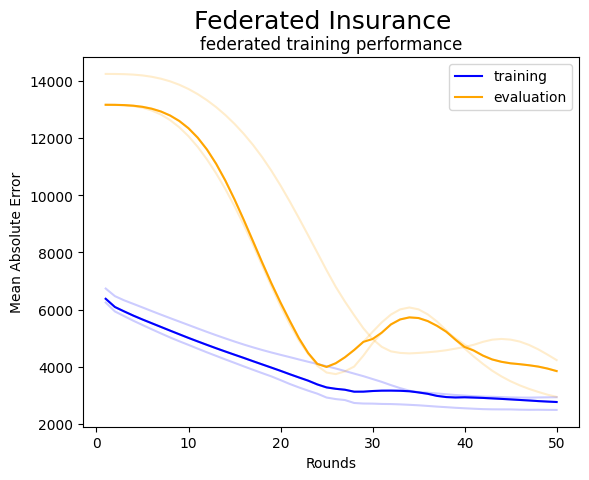

In [17]:
# plot train result

y = np.array([[hist['mean_absolute_error'] for hist in res['history']] for res in results_fed]).transpose()
yval = np.array([[hist['val_mean_absolute_error'] for hist in res['history']] for res in results_fed]).transpose()


xran = range(1,y.shape[0] + 1)
plt.plot(xran, y, color = 'blue', alpha = .2)
plt.plot(xran, np.quantile(y,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(xran, yval, color = 'orange', alpha = .2)
plt.plot(xran, np.quantile(yval,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.xlabel("Rounds")
plt.ylabel("Mean Absolute Error")
plt.suptitle('Federated Insurance', fontsize=18)
plt.title('federated training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_mae.png')
plt.show()

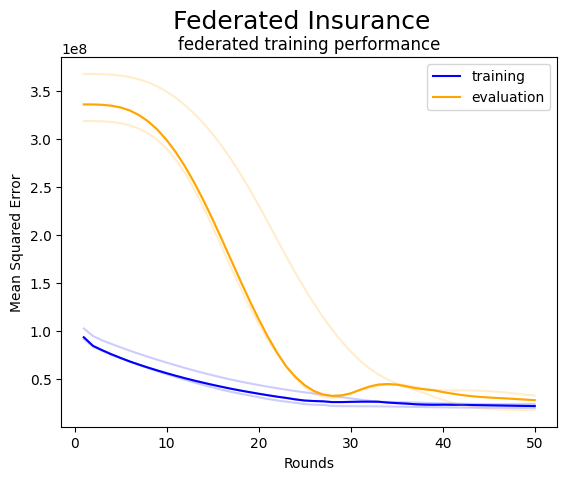

In [18]:
# plot train result

y = np.array([[hist['mean_squared_error'] for hist in res['history']] for res in results_fed]).transpose()
yval = np.array([[hist['val_mean_squared_error'] for hist in res['history']] for res in results_fed]).transpose()


xran = range(1,y.shape[0] + 1)
plt.plot(xran, y, color = 'blue', alpha = .2)
plt.plot(xran, np.quantile(y,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(xran, yval, color = 'orange', alpha = .2)
plt.plot(xran, np.quantile(yval,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.xlabel("Rounds")
plt.ylabel("Mean Squared Error")
plt.suptitle('Federated Insurance', fontsize=18)
plt.title('federated training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_mse.png')
plt.show()

### FED Test

In [19]:
# compute test 
results_fed_test = []

model = keras_blueprint(compile = True)


for i in tqdm.tqdm(range(len(results_fed))):

    # fetch test data
    clients_test = []
    for client_ind in range(len(clients)):
        indices_test = client_splits[client_ind][eval_ind][1]
        clients_test.append(clients[client_ind].iloc[indices_test])

    test_data = pd.concat(clients_test)
    X_test = test_data[features[:5]]
    y_test = test_data[target]

    # calculate test performance
    model_weights = results_fed[i]['process'].get_model_weights(results_fed[i]['state'])
    model_weights.assign_weights_to(model)
    
    perf_test = model.evaluate(X_test, y_test, verbose = 0)
    perf_test = dict(zip(model.metrics_names, perf_test))

    results_fed_test.append(perf_test)

100%|██████████| 3/3 [00:06<00:00,  2.20s/it]


In [20]:
# show test results
table2 = pd.DataFrame(results_fed_test)
table2 = table2.set_axis(['test_'+ col for col in table2.columns], axis = 1)

table2.describe()[1:].to_csv(experiment_path + "results/performance_test_overview.csv", sep = ";")
table_all = pd.concat([table, table2], axis = 1)
table_all.describe()[1:].to_csv(experiment_path + "results/performance_overview.csv", sep = ";")
table_all.to_csv(experiment_path + "results/performance.csv", sep = ";")

table_all.describe()[1:].transpose().round(4)

,mean,std,min,25%,50%,75%,max
mean_absolute_error,2.731692e+03,2.240078e+02,2.491674e+03,2.629935e+03,2.768197e+03,2.851701e+03,2.935206e+03
mean_squared_error,2.177565e+07,1.997212e+06,1.982621e+07,2.075476e+07,2.168331e+07,2.275037e+07,2.381743e+07
loss,2.184037e+07,1.992893e+06,1.988732e+07,2.082513e+07,2.176295e+07,2.281690e+07,2.387085e+07
num_examples,4.810000e+04,0.000000e+00,4.810000e+04,4.810000e+04,4.810000e+04,4.810000e+04,4.810000e+04
num_batches,3.780000e+02,0.000000e+00,3.780000e+02,3.780000e+02,3.780000e+02,3.780000e+02,3.780000e+02
val_mean_absolute_error,3.677042e+03,6.601198e+02,2.947725e+03,3.398756e+03,3.849788e+03,4.041701e+03,4.233613e+03
val_mean_squared_error,2.603908e+07,7.598254e+06,1.771940e+07,2.275286e+07,2.778632e+07,3.019892e+07,3.261152e+07
val_loss,2.579637e+07,7.494526e+06,1.755234e+07,2.259574e+07,2.763913e+07,2.991838e+07,3.219762e+07
val_num_examples,1.080000e+02,0.000000e+00,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02
val_num_batches,4.000000e+00,0.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00


## Centralized DNN
---

Using 9 Features.

In [21]:
experiment_name = '02_central_new'

experiment_path = log_path + "/" + experiment_name + "/"
if not os.path.exists(experiment_path + 'logs'): os.makedirs(experiment_path + 'logs')
if not os.path.exists(experiment_path + 'models'): os.makedirs(experiment_path + 'models')
if not os.path.exists(experiment_path + 'results'): os.makedirs(experiment_path + 'results')

### CTR Train
---

In [22]:
%%time
# compute train

results_ctr = []

for i in range(n_evals):

    train_indices = [split[1][0] for split in client_splits]
    #test_indices = [split[1][1] for split in client_splits]

    rep  = int(i / nfolds)
    fold = int(i % nfolds)
    id = "r" + str(rep) + "f" + str(fold)
    print('======= rep %s - fold %s  =======' % (rep, fold))

    data_train = pd.concat([clients[i].iloc[train_indices[i]] for i in range(len(clients))])
    X_train = data_train[features[:9]] # include regions
    y_train = data_train[target]

    model = create_keras_model(
        nfeatures = 9, 
        units = [40, 40, 20], 
        activations = ['relu'] * 3, 
        compile = compile,
        loss = "mean_absolute_error")
    #keras_blueprint(nfeatures = 9, compile = True)
    
    hist = train_model(
        model, X_train, y_train,
        epochs = n_epochs, 
        output_msr = "r2_score",
        callbacks = [CSVLogger(experiment_path + "logs/" + id + '_log.csv'  , separator =";")],
        seed = 42
    )
    model.save_weights(experiment_path + "models/" + id + '_weights.h5')

    results_ctr.append(hist)


======= rep 0 - fold 0  =======


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
# show train results
table = pd.DataFrame(
    [{key: val[-1] for key, val in hist.history.items()} for hist in results_ctr]
    ).assign(
    r2_score    = lambda x: x.r2_score * 100,
    val_r2_score = lambda x: x.val_r2_score * 100
)

table.describe()[1:].to_csv(experiment_path + "results/performance_train_overview.csv", sep = ";")
table.round(2)

,loss,mae,mean_squared_error,r2_score,val_loss,val_mae,val_mean_squared_error,val_r2_score
0,1837.54,1837.54,22446034.0,85.54,2027.64,2027.64,23490092.0,78.23
1,1884.67,1884.67,22700472.0,85.35,2107.26,2107.26,23499260.0,78.31
2,1860.57,1860.57,22315592.0,85.64,2026.73,2026.73,23777696.0,78.07


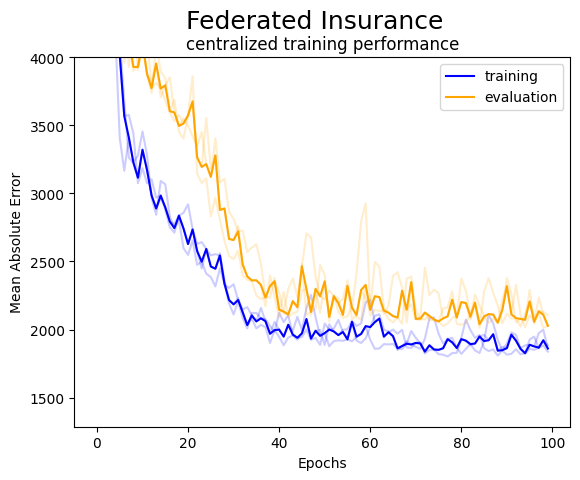

In [ ]:
# plot train result
y1 = np.array([hist.history["mae"] for hist in results_ctr]).transpose()
y2 = np.array([hist.history["val_mae"] for hist in results_ctr]).transpose()

plt.plot(y1, color = 'blue', alpha = .2)
plt.plot(np.quantile(y1,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(y2, color = 'orange', alpha = .2)
plt.plot(np.quantile(y2,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.ylim([None, 4000])

plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.suptitle('Federated Insurance', fontsize = 18)
plt.title('centralized training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_mae.png')
plt.show()


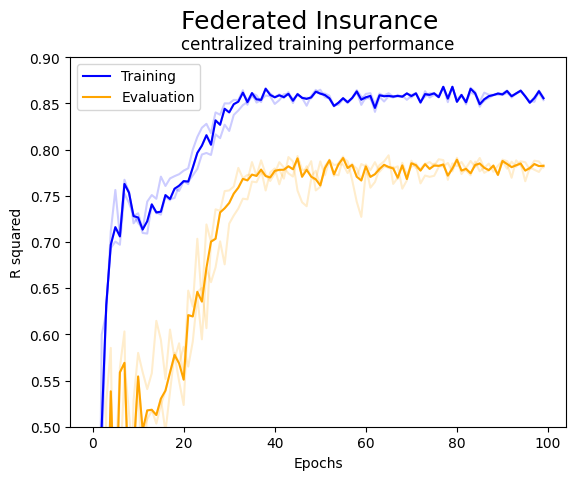

In [ ]:
# plot train result
y1 = np.array([hist.history["r2_score"] for hist in results_ctr]).transpose()
y2 = np.array([hist.history["val_r2_score"] for hist in results_ctr]).transpose()

plt.plot(y1, color = 'blue', alpha = .2)
plt.plot(np.quantile(y1,.5, axis = 1), label = 'Training', color = 'blue')
plt.plot(y2, color = 'orange', alpha = .2)
plt.plot(np.quantile(y2,.5, axis = 1), label = 'Evaluation', color = 'orange')
plt.ylim([0.5, 0.9])
plt.xlabel("Epochs")
plt.ylabel("R squared")
plt.suptitle('Federated Insurance', fontsize = 18)
plt.title('centralized training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_rsq.png')
plt.show()


### CTR Test
---

In [ ]:
# compute test
results_test_ctr = []

for i in tqdm.tqdm(range(n_evals)):
    #train_indices = [split[1][0] for split in client_splits]
    test_indices = [split[1][1] for split in client_splits]

    data_test = pd.concat([clients[i].iloc[test_indices[i]] for i in range(len(clients))])
    X_test = data_test[features[:9]]
    y_test = data_test[target]

    model = results_ctr[i].model
    perf_test  = model.evaluate(X_test, y_test, verbose = 0)
    perf_test = dict(zip(model.metrics_names, perf_test))
    results_test_ctr.append(perf_test)

100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


In [ ]:
# show test results
table2 = pd.DataFrame(results_test_ctr)
table2 = table2.set_axis(['test_'+ col for col in table2.columns], axis = 1)


table2.describe()[1:].to_csv(experiment_path + "results/performance_test_overview.csv", sep = ";")

table_all = pd.concat([table, table2], axis = 1)
table_all.describe()[1:].to_csv(experiment_path + "results/performance_overview.csv", sep = ";")
table_all.to_csv(experiment_path + "results/performance.csv", sep = ";")
table_all.describe()[1:].transpose().round(2)

,mean,std,min,25%,50%,75%,max
loss,1860.93,23.57,1837.54,1849.06,1860.57,1872.62,1884.67
mae,1860.93,23.57,1837.54,1849.06,1860.57,1872.62,1884.67
mean_squared_error,22487366.00,195740.66,22315592.00,22380813.00,22446034.00,22573253.00,22700472.00
r2_score,85.51,0.15,85.35,85.44,85.54,85.59,85.64
val_loss,2053.88,46.23,2026.73,2027.19,2027.64,2067.45,2107.26
val_mae,2053.88,46.23,2026.73,2027.19,2027.64,2067.45,2107.26
val_mean_squared_error,23589016.00,163465.96,23490092.00,23494676.00,23499260.00,23638478.00,23777696.00
val_r2_score,78.20,0.12,78.07,78.15,78.23,78.27,78.31
test_loss,2473.55,45.83,2438.40,2447.64,2456.87,2491.13,2525.38
test_mae,2473.55,45.83,2438.40,2447.64,2456.87,2491.13,2525.38
